<a href="https://colab.research.google.com/github/ArashVafa/ML-AI/blob/master/Air_pollution_forecast_using_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

TensorFlow 2.x selected.


In [0]:
#https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv

In [0]:
zip_path = tf.keras.utils.get_file(
    origin='https://archive.ics.uci.edu/ml/machine-learning-databases/00501/PRSA2017_Data_20130301-20170228.zip',
    fname='PRSA2017_Data_20130301-20170228.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

7962624/7959991 [==============================] - 0s 0us/step


In [0]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv')

In [0]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [0]:
df['pm2.5'].nunique()

581

In [0]:
df.shape

(43824, 13)

As you can see above, an observation is recorded every hour. This means that, for a single day, you will have 24 observations. 

Given a specific time, let's say you want to predict the temperature 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 120(5x24) observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.


The function below returns the above described windows of time for the model to train on. The parameter history_size is the size of the past window of information. The target_size is how far in the future does the model need to learn to predict. The target_size is the label that needs to be predicted.

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [0]:
TRAIN_SPLIT = 30000

In [0]:
tf.random.set_seed(13)

In [0]:
uni_data = df['TEMP']
uni_data.index = df['No']
uni_data.head()

No
1   -11.0
2   -12.0
3   -11.0
4   -14.0
5   -12.0
Name: TEMP, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa79311c860>],
      dtype=object)

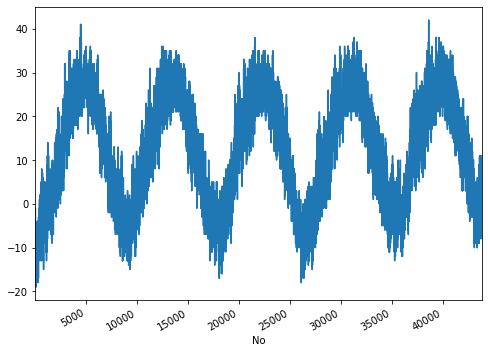

In [0]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values

It is important to scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.You could also use a tf.keras.utils.normalize method that rescales the values into a range of [0,1].

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [0]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step.

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [0]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.81134836]
 [-1.89216114]
 [-1.81134836]
 [-2.05378669]
 [-1.89216114]
 [-1.73053558]
 [-1.6497228 ]
 [-1.6497228 ]
 [-1.6497228 ]
 [-1.56891003]
 [-1.48809725]
 [-1.3264717 ]
 [-1.3264717 ]
 [-1.16484614]
 [-1.08403337]
 [-1.00322059]
 [-1.08403337]
 [-1.16484614]
 [-1.3264717 ]
 [-1.24565892]]

 Target temperature to predict
-1.3264716966554848


In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

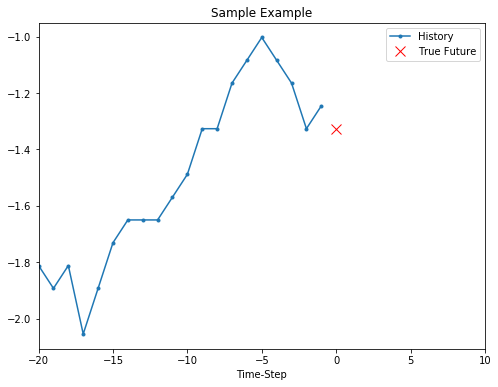

In [0]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [0]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

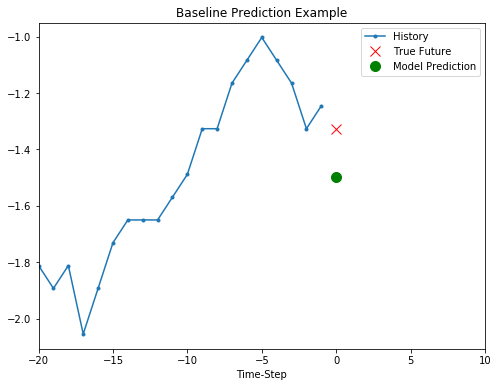

In [0]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this notebook, I will use a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

![alt text](https://miro.medium.com/max/876/1*RiQ5LRM0CLfJToI3fk7VLA.png)

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [0]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [0]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 5s 24ms/step - loss: 0.4424 - val_loss: 0.2935
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.2256 - val_loss: 0.1541
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1154 - val_loss: 0.0947
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0883 - val_loss: 0.0824
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0800 - val_loss: 0.0773
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0759 - val_loss: 0.0747
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0741 - val_loss: 0.0726
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0718 - val_loss: 0.0716
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0718 - val_loss: 0.0713
Epoch 10/10
200/200 [===========================

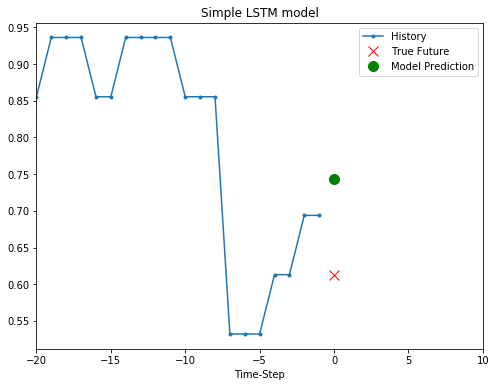

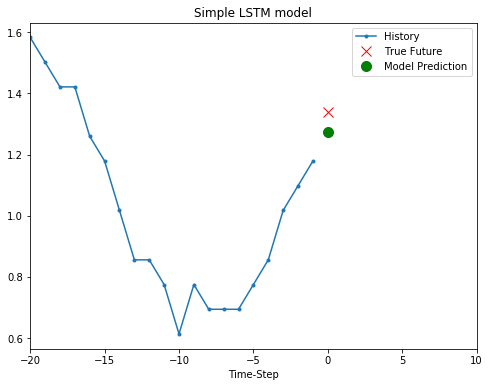

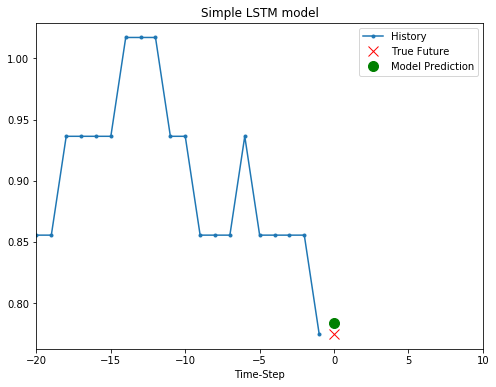

In [0]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [0]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [0]:
# Seaborn visualization library
import seaborn as sns
# Create the default pairplot
sns.pairplot(df)

Forecast a multivariate time series

The original dataset contains 13 features. For simplicity, this section considers only three of the original 13. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [0]:
features_considered = ['TEMP', 'PRES', 'Iws']#, 'pm2.5']

In [0]:
features = df[features_considered]
features.index = df['No']
features.head()

,TEMP,PRES,Iws
No,,,
1,-11.0,1021.0,1.79
2,-12.0,1020.0,4.92
3,-11.0,1019.0,6.71
4,-14.0,1019.0,9.84
5,-12.0,1018.0,12.97


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa77eb41748>,
      dtype=object)

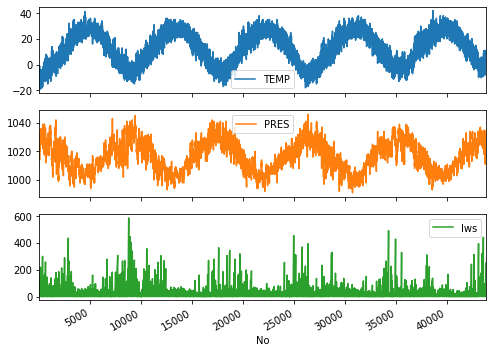

In [0]:
features.plot(subplots=True)

In [0]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [0]:
dataset = (dataset-data_mean)/data_std

In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [0]:
past_history = 120
future_target = 6
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [0]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (20, 3)


In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [0]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [0]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 7s 33ms/step - loss: 0.3210 - val_loss: 0.2274
Epoch 2/10
200/200 [==============================] - 5s 25ms/step - loss: 0.2391 - val_loss: 0.2003
Epoch 3/10
200/200 [==============================] - 5s 25ms/step - loss: 0.2205 - val_loss: 0.1915
Epoch 4/10
200/200 [==============================] - 5s 25ms/step - loss: 0.2109 - val_loss: 0.1916
Epoch 5/10
200/200 [==============================] - 5s 25ms/step - loss: 0.2080 - val_loss: 0.1870
Epoch 6/10
200/200 [==============================] - 5s 25ms/step - loss: 0.2094 - val_loss: 0.1885
Epoch 7/10
200/200 [==============================] - 5s 25ms/step - loss: 0.2064 - val_loss: 0.1833
Epoch 8/10
200/200 [==============================] - 5s 25ms/step - loss: 0.2026 - val_loss: 0.1836
Epoch 9/10
200/200 [==============================] - 5s 25ms/step - loss: 0.2037 - val_loss: 0.1842
Epoch 10/10
200/200 [===========================

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

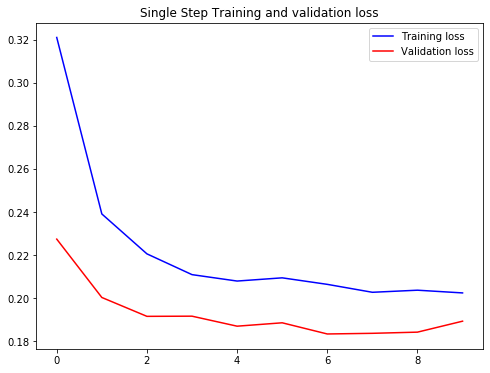

In [0]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

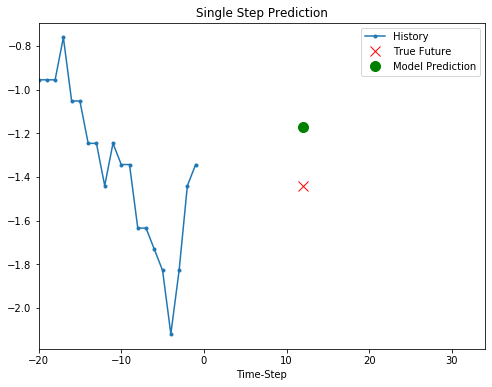

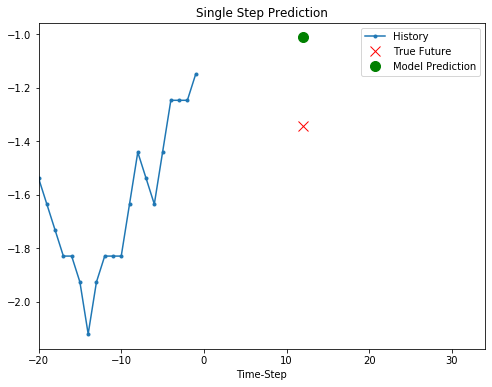

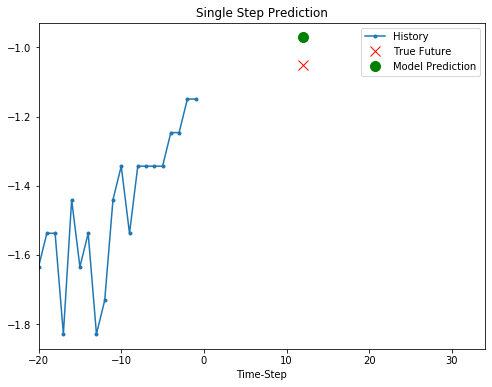

In [0]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[-1][:, 1].numpy(), y[-1].numpy(),
                    single_step_model.predict(x)[-1]], 12,
                   'Single Step Prediction')
  plot.show()

In [0]:
future_target = 12
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [0]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (20, 3)

 Target temperature to predict : (12,)


In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

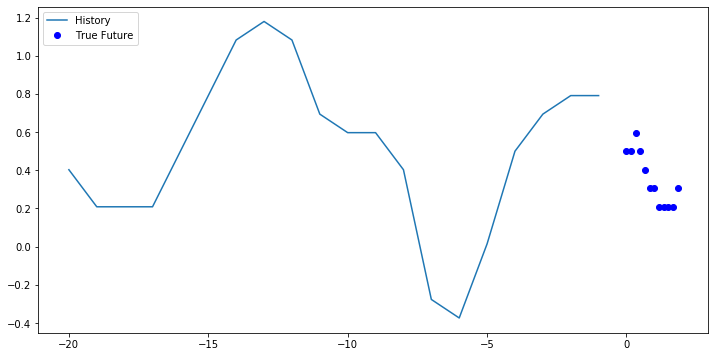

In [0]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(12))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [0]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 12)


In [0]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 10s 52ms/step - loss: 0.4227 - val_loss: 0.2850
Epoch 2/10
200/200 [==============================] - 8s 39ms/step - loss: 0.2766 - val_loss: 0.2327
Epoch 3/10
200/200 [==============================] - 8s 39ms/step - loss: 0.2460 - val_loss: 0.2248
Epoch 4/10
200/200 [==============================] - 8s 39ms/step - loss: 0.2323 - val_loss: 0.2013
Epoch 5/10
200/200 [==============================] - 8s 39ms/step - loss: 0.2253 - val_loss: 0.1955
Epoch 6/10
200/200 [==============================] - 8s 39ms/step - loss: 0.2223 - val_loss: 0.1944
Epoch 7/10
200/200 [==============================] - 8s 39ms/step - loss: 0.2184 - val_loss: 0.1985
Epoch 8/10
200/200 [==============================] - 8s 41ms/step - loss: 0.2141 - val_loss: 0.1927
Epoch 9/10
200/200 [==============================] - 8s 39ms/step - loss: 0.2136 - val_loss: 0.1896
Epoch 10/10
200/200 [==========================

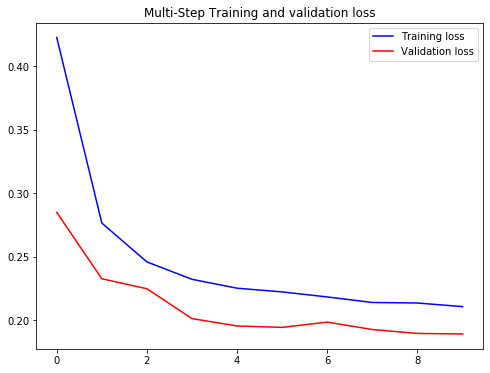

In [0]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

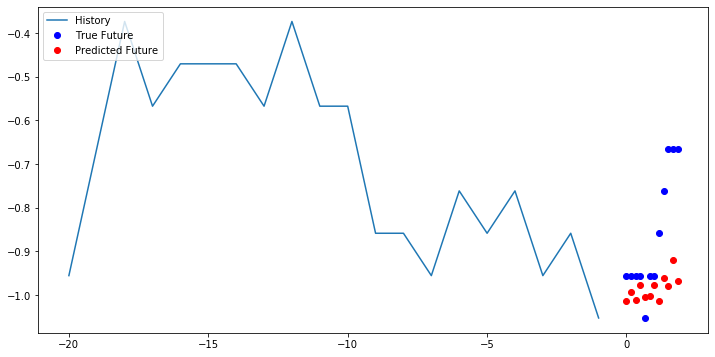

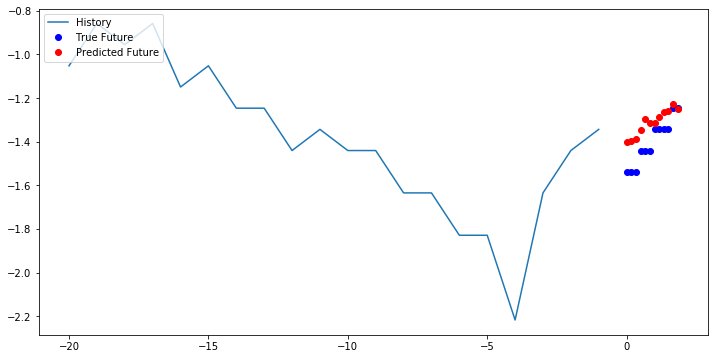

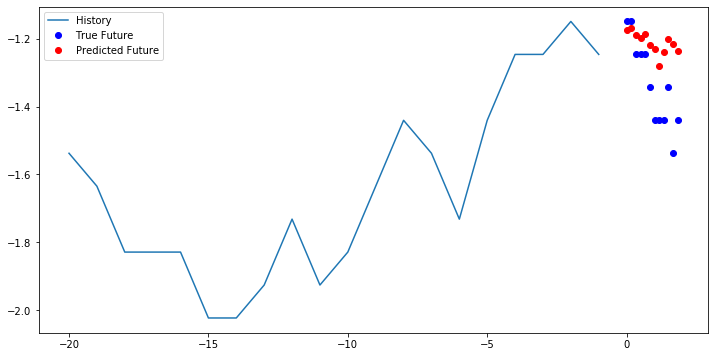

In [0]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])